<a href="https://colab.research.google.com/github/SaharYousefi92/ENGG_680_Project/blob/main/Copy_of_Untitled41.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training Data Shape: (28089, 24, 12)
Validation Data Shape: (3511, 24, 12)
Test Data Shape: (3512, 24, 12)
Epoch 1/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.0036 - mae: 0.0318 - val_loss: 0.0014 - val_mae: 0.0071
Epoch 2/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - loss: 7.7644e-04 - mae: 0.0132 - val_loss: 0.0013 - val_mae: 0.0129
Epoch 3/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - loss: 6.3064e-04 - mae: 0.0116 - val_loss: 0.0011 - val_mae: 0.0080
Epoch 4/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - loss: 6.8922e-04 - mae: 0.0111 - val_loss: 9.8690e-04 - val_mae: 0.0079
Epoch 5/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - loss: 4.7402e-04 - mae: 0.0097 - val_loss: 8.9552e-04 - val_mae: 0.0053
Epoch 6/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 4.3275e-04 - mae: 0.0093 - val_loss: 8.3317e-04 - val_mae: 0.0062
Epoch 7/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 5.1254e-04 - mae: 0.0095 - val_loss: 9.2128e-04 - val_mae: 0.0079
Epoch 8/50
87

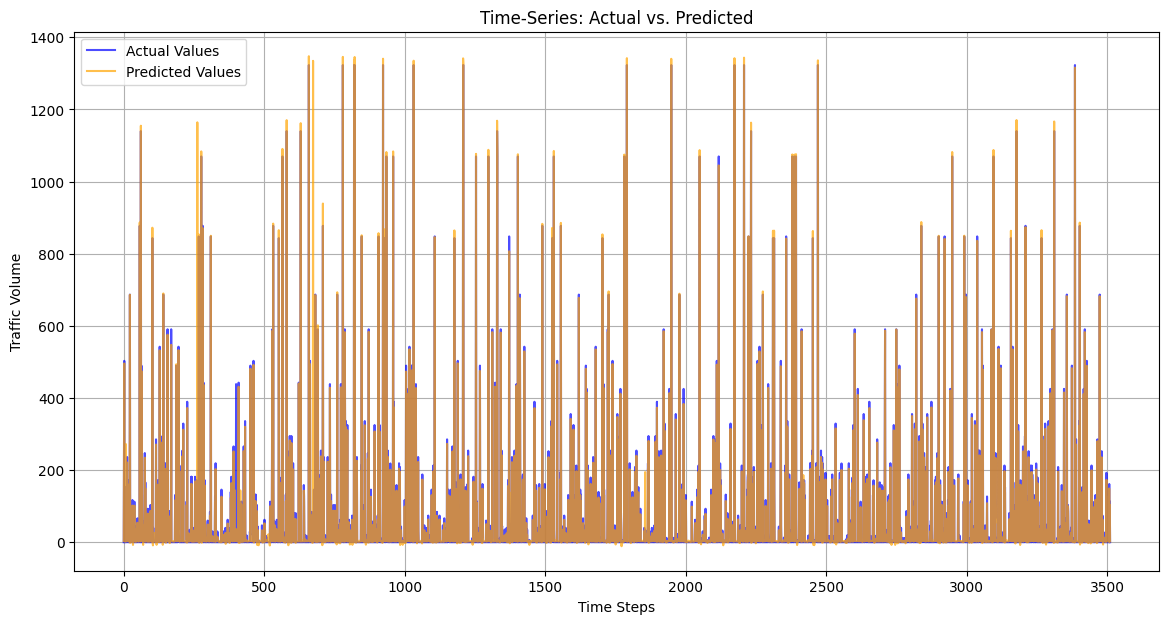

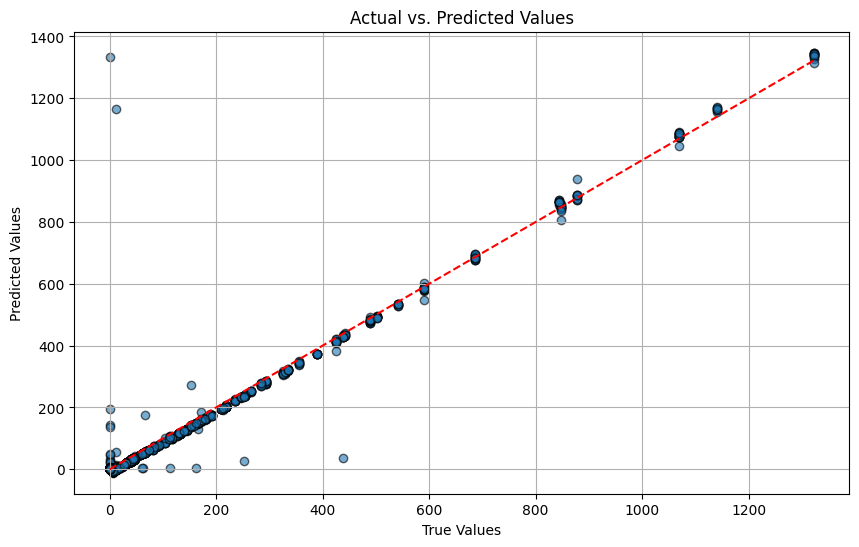

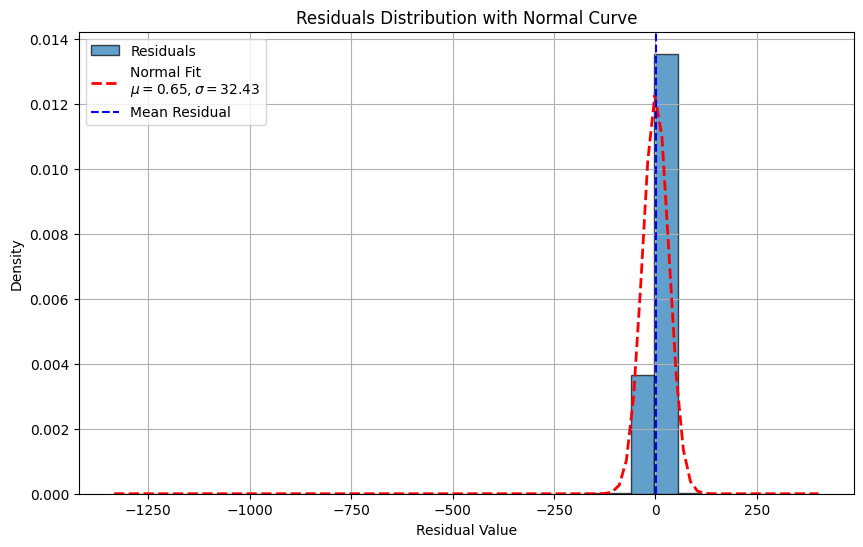

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import norm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# --- Step 1: Load the Data ---
file_path = 'combined_EB.xlsx'  # Single dataset file
data = pd.read_excel(file_path)

# --- Step 2: Preprocess the Data ---
# Convert date and time columns
data['date'] = pd.to_datetime(data['date'])
data['time'] = pd.to_datetime(data['time'], format='%H:%M:%S').dt.time

# Encode categorical variables
data['weekend/holiday (y/n)'] = data['weekend/holiday (y/n)'].map({'y': 1, 'n': 0})
data['stampede (y/n)'] = data['stampede (y/n)'].map({'y': 1, 'n': 0})
data = pd.get_dummies(data, columns=['Day_Type'], prefix='DayType')

# Add lagged weather features
data['temp_lag'] = data['temp. (C)'].shift(1).fillna(0)
data['precip_lag'] = data['daily precip. (mm)'].shift(1).fillna(0)
data['wind_lag'] = data['wind (km/h)'].shift(1).fillna(0)

# Normalize numeric features
scaler = MinMaxScaler()
features = ['vehicle count', 'temp. (C)', 'daily precip. (mm)', 'wind (km/h)',
            'temp_lag', 'precip_lag', 'wind_lag', 'weekend/holiday (y/n)', 'stampede (y/n)'] + \
           [col for col in data.columns if 'DayType_' in col]
data[features] = scaler.fit_transform(data[features])

# --- Step 3: Create Sequences ---
def create_sequences(data, sequence_length, target_col):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data.iloc[i-sequence_length:i].values)
        y.append(data.iloc[i, target_col])
    return np.array(X), np.array(y)

# Define the target column index
target_col_idx = data.columns.get_loc('vehicle count')

# Generate sequences
sequence_length = 24
X, y = create_sequences(data[features], sequence_length, target_col_idx)

# --- Step 4: Split the Data ---
# Split the data into training (80%), validation (10%), and test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Validation Data Shape: {X_val.shape}")
print(f"Test Data Shape: {X_test.shape}")

# --- Step 5: Build and Train the Model ---
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

# --- Step 6: Evaluate the Model ---
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Make predictions
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Reverse scaling for evaluation
y_test_actual = scaler.inverse_transform(
    np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features) - 1))))
)[:, 0]
y_test_pred_actual = scaler.inverse_transform(
    np.hstack((y_test_pred, np.zeros((y_test_pred.shape[0], len(features) - 1))))
)[:, 0]

# --- Step 7: Calculate Metrics ---
# Validation metrics
val_mse = mean_squared_error(y_val, y_val_pred.flatten())
val_mae = mean_absolute_error(y_val, y_val_pred.flatten())
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, y_val_pred.flatten())

# Test metrics
test_mse = mean_squared_error(y_test_actual, y_test_pred_actual)
test_mae = mean_absolute_error(y_test_actual, y_test_pred_actual)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_actual, y_test_pred_actual)

# --- Step 8: Print Metrics ---
metrics_table = pd.DataFrame({
    'Metric': [
        'Validation R-squared (R²)', 'Validation Mean Squared Error (MSE)',
        'Validation Mean Absolute Error (MAE)', 'Validation Root Mean Squared Error (RMSE)',
        'Test R-squared (R²)', 'Test Mean Squared Error (MSE)',
        'Test Mean Absolute Error (MAE)', 'Test Root Mean Squared Error (RMSE)'
    ],
    'Value': [
        val_r2, val_mse, val_mae, val_rmse,
        test_r2, test_mse, test_mae, test_rmse
    ]
})

print("\n--- Validation and Test Metrics ---")
print(metrics_table)

# Save predictions as CSV
predicted_vehicle_count = pd.DataFrame({
    'Actual': y_test_actual,
    'Predicted': y_test_pred_actual
})
predicted_vehicle_count.to_csv("predicted_vehicle_count.csv", index=False)

print("\nPredicted vehicle count saved to 'predicted_vehicle_count.csv'.")

# --- Step 9: Visualizations ---
# Time-series visualization
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label="Actual Values", color='blue', alpha=0.7)
plt.plot(y_test_pred_actual, label="Predicted Values", color='orange', alpha=0.7)
plt.title("Time-Series: Actual vs. Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot: Actual vs. Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_test_pred_actual, alpha=0.6, edgecolors='k')
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], 'r', linestyle='--')
plt.title("Actual vs. Predicted Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()

# Residuals histogram with normal curve overlay
residuals = y_test_actual - y_test_pred_actual

# Fit a normal distribution to the residuals
mu, std = norm.fit(residuals)

# Plot the histogram of the residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, density=True, alpha=0.7, edgecolor='black', label='Residuals')

# Add the normal distribution curve
x = np.linspace(min(residuals), max(residuals), 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r--', linewidth=2, label=f'Normal Fit\n$\mu={mu:.2f}, \sigma={std:.2f}$')

# Plot mean line
plt.axvline(mu, color='blue', linestyle='--', linewidth=1.5, label='Mean Residual')

# Add labels, legend, and grid
plt.title("Residuals Distribution with Normal Curve")
plt.xlabel("Residual Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def preprocess_input(temp, precip, wind, weekend_holiday, stampede, day_type):
    # Lagged features are set to zero
    temp_lag, precip_lag, wind_lag = temp, precip, wind

    # Encode weekend/holiday and stampede flags
    weekend_holiday = 1 if weekend_holiday.lower() == 'y' else 0
    stampede = 1 if stampede.lower() == 'y' else 0

    # Encode day type (Sunny, Rainy, Snowy) into one-hot format
    day_type_cols = [col for col in data.columns if 'DayType_' in col]
    day_type_one_hot = [1 if day_type.lower() in col.lower() else 0 for col in day_type_cols]

    # Add zeros for any missing day type columns
    while len(day_type_one_hot) < len(day_type_cols):
        day_type_one_hot.append(0)

    # Combine all features, including a placeholder for 'vehicle count'
    # We'll use 0 as a placeholder, as it will be scaled later
    input_features = [0, temp, precip, wind, temp_lag, precip_lag, wind_lag, weekend_holiday, stampede] + day_type_one_hot

    # Ensure the input features match the scaler's expected feature names and order
    input_features = pd.DataFrame([input_features], columns=features)

    # Scale the features
    input_features_scaled = scaler.transform(input_features)
    return input_features_scaled

def predict_traffic_for_datetime():
    print("\nEnter the following details to predict traffic volume for a specific date and time:")

    # Input temperature, precipitation, and wind speed
    temp = float(input("Enter Temperature (C): "))
    precip = float(input("Enter Daily Precipitation (mm): "))
    wind = float(input("Enter Wind Speed (km/h): "))

    # Input holiday, stampede, and day type
    weekend_holiday = input("Is it a weekend or holiday? (y/n): ").strip()
    while weekend_holiday.lower() not in ['y', 'n']:
        weekend_holiday = input("Invalid input. Is it a weekend or holiday? (y/n): ").strip()

    stampede = input("Is it during Stampede? (y/n): ").strip()
    while stampede.lower() not in ['y', 'n']:
        stampede = input("Invalid input. Is it during Stampede? (y/n): ").strip()

    day_type = input("Enter Day Type (Sunny/Rainy/Snowy): ").strip().lower()
    while day_type not in ['sunny', 'rainy', 'snowy']:
        day_type = input("Invalid day type. Enter Day Type (Sunny/Rainy/Snowy): ").strip().lower()

    # Input future date and time
    date_time_str = input("Enter Date and Time (YYYY-MM-DD HH:MM:SS): ").strip()
    date_time = validate_date_time(date_time_str)

    # Preprocess the input
    input_features = preprocess_input(temp, precip, wind, weekend_holiday, stampede, day_type)

    # Create a sequence format for the LSTM model (24-hour context with repeated input)
    input_sequence = np.tile(input_features, (24, 1)).reshape(1, 24, -1)

    # Predict traffic volume using the trained model
    predicted_volume_scaled = model.predict(input_sequence)
    predicted_volume = scaler.inverse_transform(
        np.hstack((predicted_volume_scaled, np.zeros((predicted_volume_scaled.shape[0], len(features) - 1))))
    )[:, 0]

    print(f"\nFor the date and time '{date_time_str}', the predicted traffic volume is: {predicted_volume[0]:.2f} vehicles")

# Call the function to predict traffic for a specific date and time
predict_traffic_for_datetime()



Enter the following details to predict traffic volume for a specific date and time:
Enter Temperature (C): -19
Enter Daily Precipitation (mm): 37
Enter Wind Speed (km/h): 10
Is it a weekend or holiday? (y/n): n
Is it during Stampede? (y/n): n
Enter Day Type (Sunny/Rainy/Snowy): Snowy
Enter Date and Time (YYYY-MM-DD HH:MM:SS): 2024-11-29 11:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

For the date and time '2024-11-29 11:00:00', the predicted traffic volume is: 1607.98 vehicles
